In [47]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [48]:
import numpy as np
import pandas as pd
import re
import itertools
import string
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



In [49]:

def filter_data(df, position, min_snap_pct, min_games):


    ## Filtering the dataframe.. just want to work with QBs for now 
    qb_df = df.loc[df['starter_pos'] == position].reset_index(drop=True)
    
    
    ## converting game location to home and away 
    qb_df['game_location'] = qb_df['game_location'].apply(lambda x: 'home' if pd.isnull(x) else 'away')
    
    ### Dropping any rows with NaN at offensive snap percentage 
    qb_df.drop(qb_df[qb_df['off_pct'].isnull()].index, inplace=True)

    ## convert strings to percentages 
    qb_df['off_pct'] = qb_df['off_pct'].apply(lambda x: float(x.strip('%')))
    qb_df['def_pct'] = qb_df['def_pct'].apply(lambda x: float(x.strip('%')))
    qb_df['st_pct'] = qb_df['st_pct'].apply(lambda x: float(x.strip('%')))

    ### converting game result column to four columns.. result,total_scorem, points_for, points_against
    ### 


    qb_df['result'] = qb_df['game_result'].apply(lambda x: re.split(' |-', x)[0])
    qb_df['pf'] = qb_df['game_result'].apply(lambda x: int(re.split(' |-', x)[1]))
    qb_df['pa'] = qb_df['game_result'].apply(lambda x: int(re.split(' |-', x)[2]))
    qb_df['ptotal'] = qb_df['pf'] + qb_df['pa']
    ### Now let's select playes who have played more than x number of games and y average snap count percentage in a year 
    test = qb_df.loc[qb_df['off_pct'] > min_snap_pct].reset_index(drop=True)


    #### There are these outliers like sam bradford who are morons and dunno what to do with them
    ### Maybe later i can remove any game with less than 5.0 fantasy points and more than 30 or something fantasy 
    ### points NEED TO THINK MORE ABOUT THIS LATERSS 
    ## test.loc[test['draftkings_points'] == 2.6000]


    game_count = test['name'].value_counts()
    game_count = game_count.loc[game_count.values > min_games]
    sel_players = game_count.keys().tolist()

    fin_qb_df = test.loc[test['name'].isin(sel_players)].reset_index(drop=True)
    
    #### Team names need to be consistent as a couple of teams changed their names recently 
    fin_qb_df['team'] = fin_qb_df['team'].apply(lambda x: 'LAR' if x == 'STL' else x)
    fin_qb_df['opp'] = fin_qb_df['opp'].apply(lambda x: 'LAR' if x == 'STL' else x)
    fin_qb_df['team'] = fin_qb_df['team'].apply(lambda x: 'LAC' if x == 'SDG' else x)
    fin_qb_df['opp'] = fin_qb_df['opp'].apply(lambda x: 'LAC' if x == 'SDG' else x)
    
    
    
    ########### DROPPING GAME 16 BECAUSE THAT IS WEEK 17 AND IS USELESS 
    ### Dropping any rows with NaN at offensive snap percentage 
    fin_qb_df.drop(fin_qb_df[fin_qb_df['game_num'] == 16].index, inplace=True)
    
    

    ## we only need some of the columns selecting them first 
    fin_qb_df = fin_qb_df.drop(['special_teams', 'fantasy_points', 'fanduel_points', 'game_result','defense','def_pct',
               'st_pct','lnk_id','pf','pa','ptotal','result','off_pct','offense'], axis=1)


    

    return fin_qb_df 

In [50]:
#### Compiling Training data
### We are going to use 2011 to 2017 data to train the model and then test on 2018 data 

yr_list = np.arange(2012,2019,1)

##yr_list = [2017]
position = 'QB'
min_snap_pct = 50.0
#min_snap_pct = 90.0
min_games = 8
#min_games = 10
tr_df = pd.DataFrame(columns=())
for yr in yr_list:
    print(yr)
    fname = 'total_profootball_'+str(yr)+'_fantasy_data.csv'
    tdf = pd.read_csv(fname,index_col=[0])
    tdf = filter_data(tdf,position,min_snap_pct,min_games)
    tr_df = pd.concat([tr_df, tdf], axis=0).reset_index(drop=True)

    


2012
2013
2014
2015
2016
2017
2018


In [51]:
tr_df.to_csv('Compiled_fantasy_stats.csv')
tr_df.head(5)

,game_date,opp,starter_pos,draftkings_points,team,game_num,game_location,name,year
0,2012-09-09,WAS,QB,26.6,NOR,1,home,Drew Brees,2012.0
1,2012-09-16,CAR,QB,24.0,NOR,2,away,Drew Brees,2012.0
2,2012-09-23,KAN,QB,20.5,NOR,3,home,Drew Brees,2012.0
3,2012-09-30,GNB,QB,32.8,NOR,4,away,Drew Brees,2012.0
4,2012-10-07,LAC,QB,32.6,NOR,5,home,Drew Brees,2012.0


In [7]:
tr_df.describe()



,draftkings_points,game_num,year
count,2767.000000,2767.000000,2767.000000
mean,18.546512,7.961691,2015.030358
std,8.145002,4.282333,2.016513
min,-0.900000,1.000000,2012.000000
25%,12.700000,4.000000,2013.000000
50%,17.700000,8.000000,2015.000000
75%,23.800000,12.000000,2017.000000
max,49.300000,15.000000,2018.000000


In [8]:
## Removing all anything below 2 standard deviations 
tr_df = tr_df.loc[(tr_df['draftkings_points'] >= 2.44)]
tr_df.describe()

,draftkings_points,game_num,year
count,2755.000000,2755.000000,2755.000000
mean,18.622069,7.961525,2015.032305
std,8.081449,4.282589,2.015564
min,2.500000,1.000000,2012.000000
25%,12.800000,4.000000,2013.000000
50%,17.700000,8.000000,2015.000000
75%,23.900000,12.000000,2017.000000
max,49.300000,15.000000,2018.000000


# Labeling the Data

In [52]:
### Adding labels 

hpt = int(tr_df['draftkings_points'].quantile(0.50).round(0))
lpt = int(tr_df['draftkings_points'].quantile(0.25).round(0))

### 1 for easy, 2 for medium, 3 for tough

tr_df['dfk_labels'] = [0]*len(tr_df)

tr_df['dfk_labels'] = tr_df['draftkings_points'].apply(lambda x: 'QB1' if x >= hpt else('QB3' if x <= lpt else 'QB2'))

tr_df.head(10)

,game_date,opp,starter_pos,draftkings_points,team,game_num,game_location,name,year,dfk_labels
0,2012-09-09,WAS,QB,26.6,NOR,1,home,Drew Brees,2012.0,QB1
1,2012-09-16,CAR,QB,24.0,NOR,2,away,Drew Brees,2012.0,QB1
2,2012-09-23,KAN,QB,20.5,NOR,3,home,Drew Brees,2012.0,QB1
3,2012-09-30,GNB,QB,32.8,NOR,4,away,Drew Brees,2012.0,QB1
4,2012-10-07,LAC,QB,32.6,NOR,5,home,Drew Brees,2012.0,QB1
5,2012-10-21,TAM,QB,33.2,NOR,6,away,Drew Brees,2012.0,QB1
6,2012-10-28,DEN,QB,15.7,NOR,7,away,Drew Brees,2012.0,QB2
7,2012-11-05,PHI,QB,16.5,NOR,8,home,Drew Brees,2012.0,QB2
8,2012-11-11,ATL,QB,22.8,NOR,9,home,Drew Brees,2012.0,QB1
9,2012-11-18,OAK,QB,20.8,NOR,10,away,Drew Brees,2012.0,QB1


# 1. Overall QB Performance

In [13]:
#### Selecting players who have played atleast 15 games 
plrs = tr_df['name'].value_counts()
plrs_sel = plrs[plrs >= 15].index

qb_df = tr_df[tr_df['name'].isin(plrs_sel)].reset_index(drop=True)

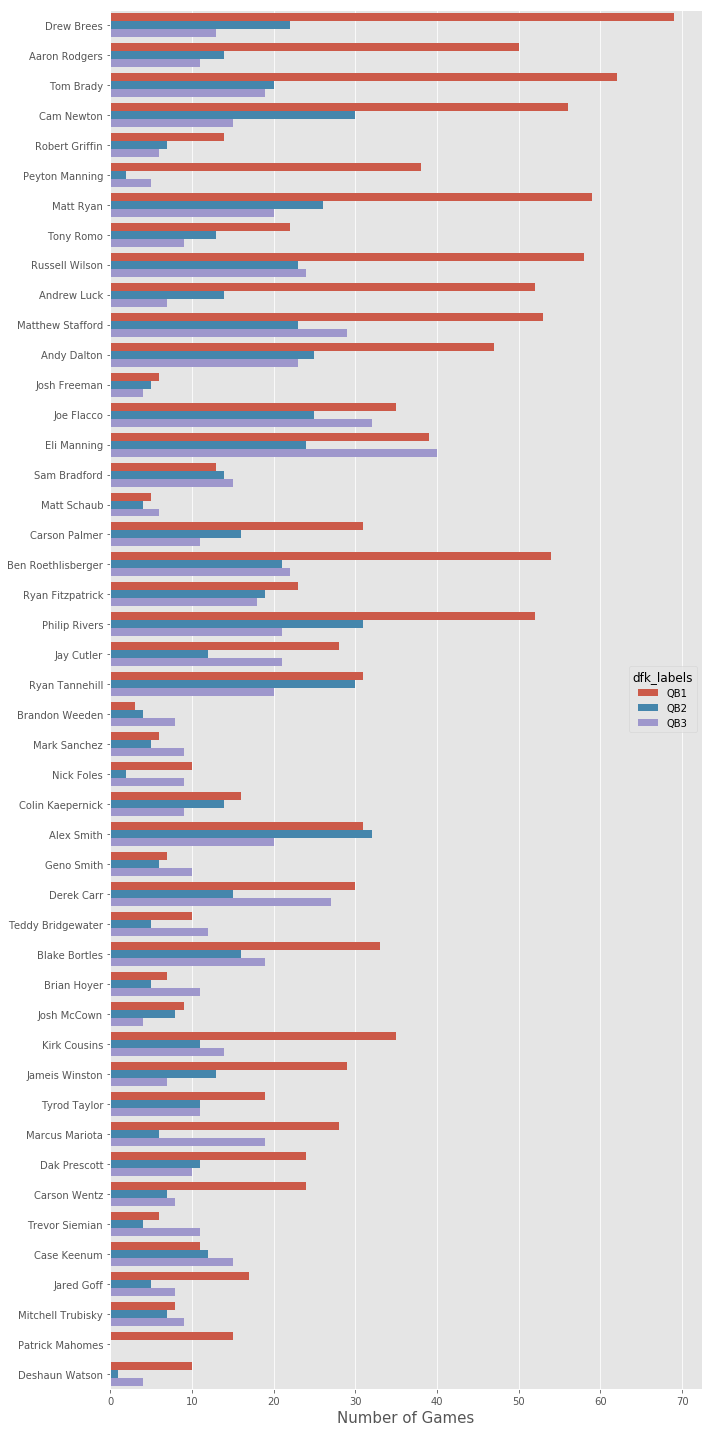

In [53]:
## Plot of all the games 
plt.style.use('ggplot')
plt.figure(figsize=(10,20))
g = sns.countplot(y='name', hue='dfk_labels', data=qb_df)
plt.xlabel('Number of Games',size = 15)
plt.ylabel('')
plt.tight_layout()
plt.savefig('overall_performance.png')

# 1.b Overall QB1 performances

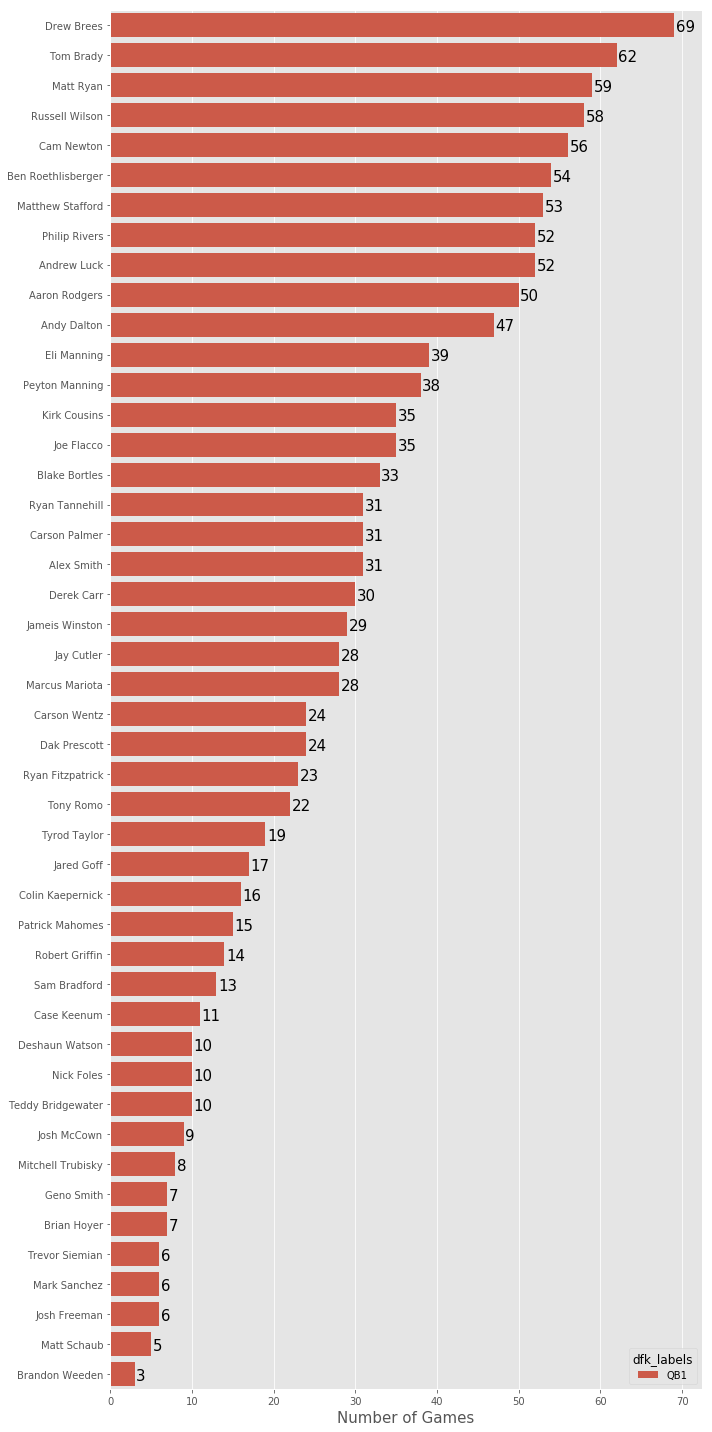

In [15]:
# Selecting only greater than equal to QB1 positions 
plt.style.use('ggplot')
qb1_df = qb_df[(qb_df['dfk_labels'] == 'QB1')].reset_index(drop=True)
cts = qb1_df['name'].value_counts()
qb_ord = cts.index




plt.figure(figsize=(10,20))
g = sns.countplot(y='name', hue = 'dfk_labels',order = cts.index, data=qb1_df)
performance_counts = pd.DataFrame(qb1_df['name'].value_counts()).reset_index()
for index, row in performance_counts.iterrows():
    g.text(row['name'] + 0.2, row.name + 0.2, 
           row['name'], color='black', ha="left", size=15)

plt.xlabel('Number of Games',size = 15)
plt.ylabel('')
plt.tight_layout()
plt.savefig('overall_qb1_performance.png')

# 1.c Overall QB1 Percentage Performance

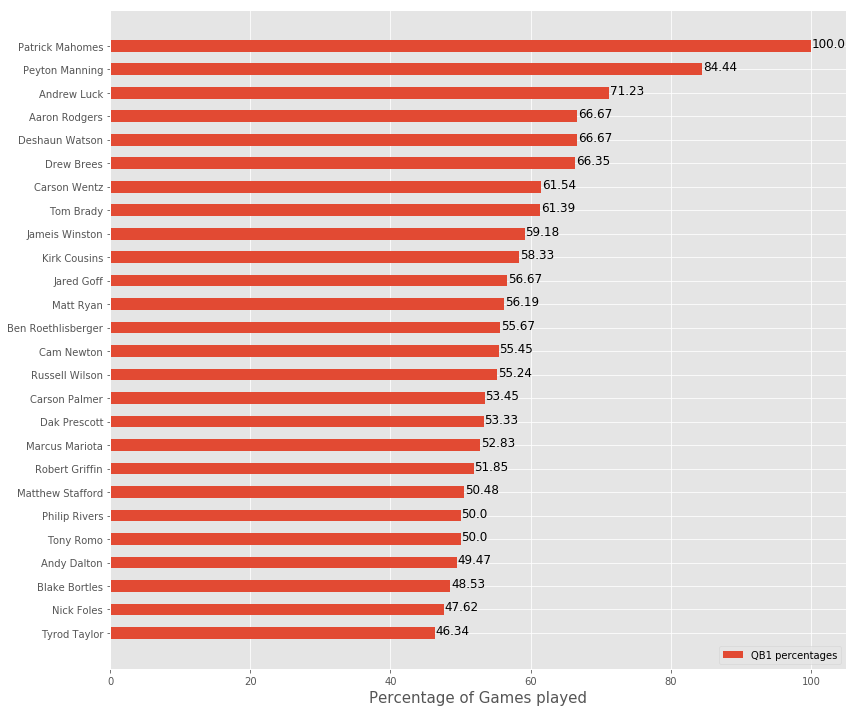

In [113]:
### It still doesn't tell us the whole story, let's try to look at the percentages 
## Aggregate Metrics for sel players
agg_met_qb = pd.DataFrame(columns=['name','QB1','ngames'])
for i in range(len(plrs_sel)):
    agg_met_qb.loc[i] = [plrs_sel[i]] + [cts[plrs_sel[i]]] + [plrs[plrs_sel[i]]]
agg_met_qb['perc'] = agg_met_qb['QB1']*100/agg_met_qb['ngames']
agg_met_qb = agg_met_qb.sort_values(['perc'], ascending=[1]).reset_index(drop=True)


## Plot of all the games 
bar_width = 0.50
plot_df = agg_met_qb.loc[20:].reset_index(drop=True)

plt.figure(figsize=(12,10))
plt.barh(plot_df['name'],plot_df['perc'], bar_width, label = 'QB1 percentages')
for index, row in plot_df.iterrows():
    plt.text(round(row['perc'],2)+ 0.1, row.name - 0.05,
           round(row['perc'],2), color='black', size=12)

plt.xlabel('Percentage of Games played',size = 15)
plt.ylabel('')
plt.tight_layout()
plt.legend(loc='lower right')
plt.savefig('overall_qb1_percentages.png')

# 1.d Experienced QB1 performances

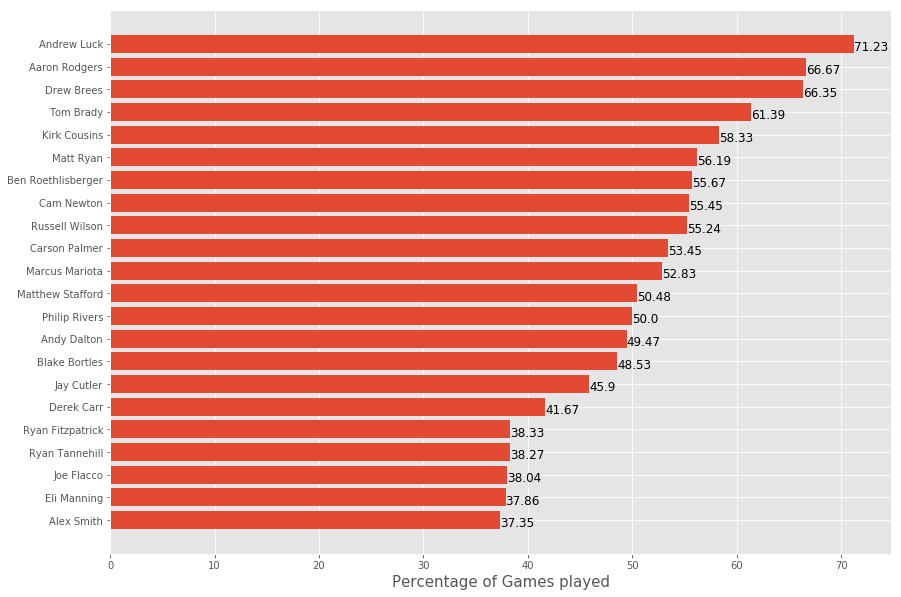

In [121]:
### Selecting QBs who have played more than 50 games 
sel_qb = agg_met_qb[agg_met_qb['ngames'] >= 50]
sel_qb = sel_qb.sort_values(['perc'], ascending=[1]).reset_index(drop=True)


## Plot of all the games 
bar_width = 0.50
plt.figure(figsize=(14,10))
plt.barh(sel_qb['name'],sel_qb['perc'])
for index, row in sel_qb.iterrows():
    plt.text(round(row['perc'],2) + 0.01, row.name - 0.3,
           round(row['perc'],2), color='black', ha="left", size=12)

plt.xlabel('Percentage of Games played',size = 15)
plt.ylabel('')
plt.savefig('qb1_percentages_seniors.png')

# 1.d Top QB performance comparison 

In [19]:
##### Team Dataframe
tm_sel = tr_df['opp'].value_counts()
tm_cts = qb1_df['opp'].value_counts()

agg_met_tm = pd.DataFrame(columns=['opp','QB1','ngames'])
for i in range(len(tm_sel)):
    agg_met_tm.loc[i] = [tm_sel.index[i]] + [tm_cts[tm_sel.index[i]]] + [tm_sel[tm_sel.index[i]]]
agg_met_tm['perc'] = agg_met_tm['QB1']/agg_met_tm['ngames']
agg_met_tm = agg_met_tm.sort_values(['perc'], ascending=[0]).reset_index(drop=True)

## Labeling teams as easy, medium, tough 

agg_met_tm['fstr'] = [0]*len(agg_met_tm)
agg_met_tm['fstr'] = agg_met_tm['perc'].apply(lambda x: 'weak' if x > 0.50 else ('tough' if x < 0.40 else 'average'))


## Merging on the qb1 dataframe 
qb1_df = pd.merge(qb1_df, agg_met_tm, on=['opp'])



In [20]:
### Selecting special QBs
sp_qb = sel_qb[sel_qb['perc'] >= 61].reset_index(drop=True)


## Special QB performance against different teams 
for i in qb1_df.fstr.unique():
    sp_qb[i] = qb1_df['name'][qb1_df['fstr'] == i].value_counts()[sp_qb.name.tolist()].tolist()
    
sp_qb['perc_weak'] = sp_qb['weak']*100/sp_qb['QB1']
sp_qb['perc_average'] = sp_qb['average']*100/sp_qb['QB1']
sp_qb['perc_tough'] = sp_qb['tough']*100/sp_qb['QB1']
sp_qb

,name,QB1,ngames,perc,weak,average,tough,perc_weak,perc_average,perc_tough
0,Tom Brady,62,101,61.3861,20,27,15,32.2581,43.5484,24.1935
1,Drew Brees,69,104,66.3462,34,29,6,49.2754,42.029,8.69565
2,Aaron Rodgers,50,75,66.6667,18,29,3,36,58,6
3,Andrew Luck,52,73,71.2329,16,30,6,30.7692,57.6923,11.5385


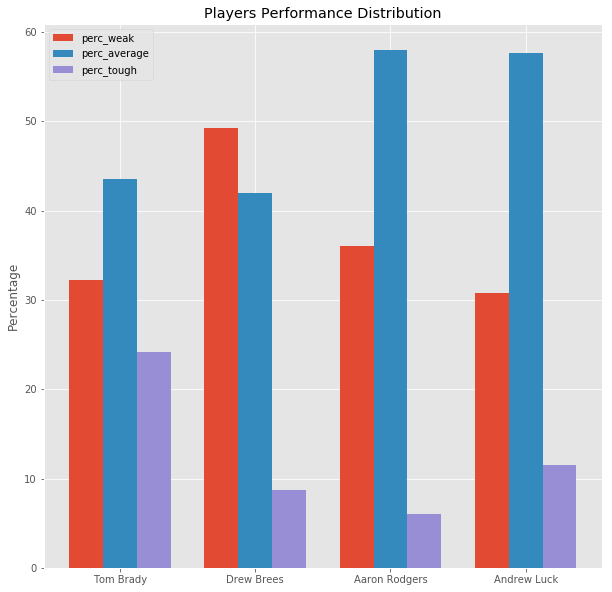

In [122]:
## Plot of all the games 

bar_width = 0.25
ngroups = 4
index = np.arange(ngroups)

plt.figure(figsize=(10,10))
plt.bar(index,sp_qb['perc_weak'],bar_width,label = 'perc_weak')
# for index, row in sp_qb.iterrows():
#     plt.text(round(row['perc_easy'],2) + 0.01, row.name - 0.3,
#            round(row['perc_easy'],2), color='black', ha="left", size=15)

    
plt.bar(index+bar_width,sp_qb['perc_average'],bar_width,label = 'perc_average')
# for index, row in sp_qb.iterrows():
#     plt.text(round(row['perc_average'],2) + 0.01, row.name - 0.3,
#            round(row['perc_average'],2), color='black', ha="left", size=15)

plt.bar(index+ 2*bar_width,sp_qb['perc_tough'],bar_width,label = 'perc_tough')
# for index, row in sp_qb.iterrows():
#     plt.text(round(row['perc_tough'],2) + 0.01, row.name - 0.3,
#            round(row['perc_tough'],2), color='black', ha="left", size=15)

plt.ylabel('Percentage')
plt.xlabel('')
plt.title('Players Performance Distribution')
plt.xticks(index + bar_width, ('Tom Brady', 'Drew Brees', 'Aaron Rodgers', 'Andrew Luck'))
plt.legend()

plt.savefig('top_four_distribution.png')

# 2. Superbowl Winner Analysis 

In [22]:
####################### SUPER BOWL ANALYSIS #################


#### Compiling Training data
### We are going to use 2011 to 2017 data to train the model and then test on 2018 data 

yr_list = np.arange(2012,2019,1)

##yr_list = [2017]
position = 'QB'
min_snap_pct = 25.0
#min_snap_pct = 90.0
min_games = 3
#min_games = 10
tr_df = pd.DataFrame(columns=())
for yr in yr_list:
    print(yr)
    fname = 'total_profootball_'+str(yr)+'_fantasy_data.csv'
    tdf = pd.read_csv(fname,index_col=[0])
    tdf = filter_data(tdf,position,min_snap_pct,min_games)
    tr_df = pd.concat([tr_df, tdf], axis=0).reset_index(drop=True)

    




2012
2013
2014
2015
2016
2017
2018


In [23]:
sel_df = tr_df.copy()

#hpt = int(tr_df['draftkings_points'].quantile(0.75).round(0))
hpt = int(sel_df['draftkings_points'].quantile(0.50).round(0))
lpt = int(sel_df['draftkings_points'].quantile(0.25).round(0))

### 1 for easy, 2 for medium, 3 for tough

sel_df['dfk_labels'] = [0]*len(sel_df)

sel_df['dfk_labels'] = sel_df['draftkings_points'].apply(lambda x: 1 if x >= hpt else(3 if x <= lpt else 2))
 

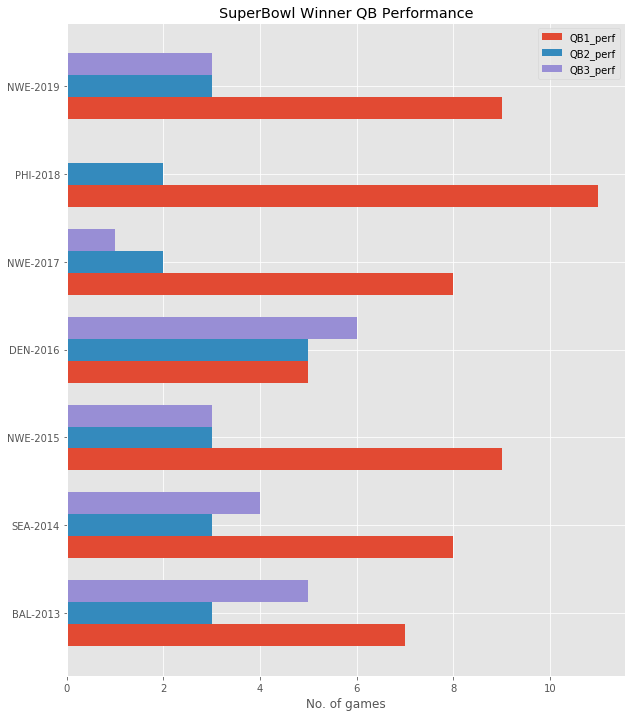

In [126]:
## Crosstab analysis to create QB performance dataframe for the winning teams 

diff_tm= pd.crosstab([sel_df.year, sel_df.dfk_labels],sel_df.team ,  margins=True)

#sb_win = [2013,'SEA','NWE','DEN','NWE','PHI','NWE']

sb_dict = {1:'BAL',2:'SEA',3:'NWE',4:'DEN',5:'NWE',6:'PHI',7:'NWE',}



wqb_df = pd.DataFrame(columns = np.arange(2013,2020,1))
yr_list = np.arange(2012,2019,1)

for i in range(len(yr_list)):
    tlist = []
    for j in range(1,4):
        tlist.append(diff_tm.loc[yr_list[i],j][sb_dict[i+1]])
    wqb_df[yr_list[i]+1] = tlist

wqb_df = wqb_df.T
wqb_df['year'] = wqb_df.index.tolist()

wqb_df = wqb_df.reset_index(drop=True)


## PLOT Results#################
bar_width = 0.25
ngroups = 7
index = np.arange(2013,2020,1)

plt.figure(figsize=(10,12))
plt.barh(index,wqb_df[0],bar_width,label = 'QB1_perf')   
plt.barh(index+bar_width,wqb_df[1],bar_width,label = 'QB2_perf')
plt.barh(index+ 2*bar_width,wqb_df[2],bar_width,label = 'QB3_perf')


plt.xlabel('No. of games')
plt.ylabel('')
plt.title('SuperBowl Winner QB Performance')
plt.yticks(index + bar_width, ('BAL-2013','SEA-2014','NWE-2015','DEN-2016','NWE-2017','PHI-2018','NWE-2019'))
plt.legend()

plt.savefig('superbowl_winner_qb_performance.png')

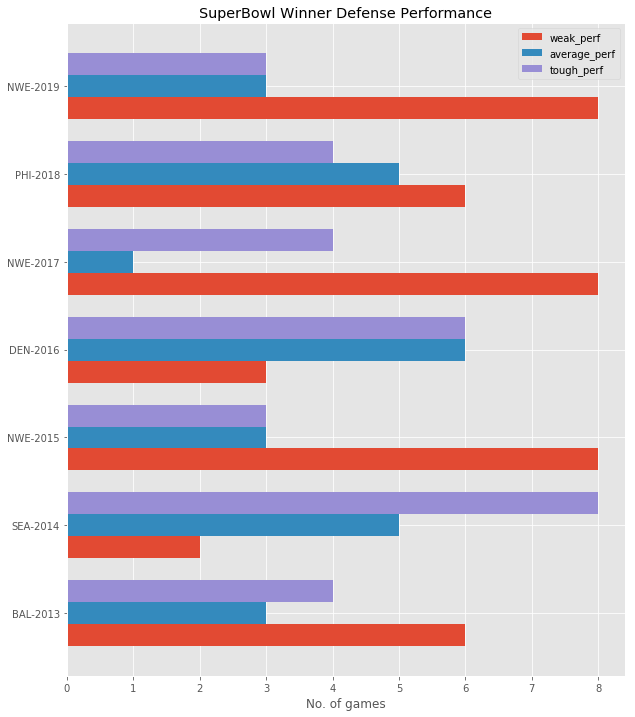

In [125]:
diff_tm= pd.crosstab([sel_df.year, sel_df.dfk_labels],sel_df.opp ,  margins=True)
#sb_win = ['BAL','SEA','NWE','DEN','NWE','PHI','NWE']
sb_dict = {1:'BAL',2:'SEA',3:'NWE',4:'DEN',5:'NWE',6:'PHI',7:'NWE',}


wdef_df = pd.DataFrame(columns = np.arange(2013,2020,1))

yr_list = np.arange(2012,2019,1)

for i in range(len(yr_list)):
    tlist = []
    for j in range(1,4):
        tlist.append(diff_tm.loc[yr_list[i],j][sb_dict[i+1]])
    wdef_df[yr_list[i]+1] = tlist
    
wdef_df = wdef_df.T
wdef_df['year'] = wdef_df.index.tolist()

wdef_df = wdef_df.reset_index(drop=True)

#################Plot Results##################
bar_width = 0.25
ngroups = 7
index = np.arange(2013,2020,1)

plt.figure(figsize=(10,12))
plt.barh(index,wdef_df[0],bar_width,label = 'weak_perf')
# for index, row in sp_qb.iterrows():
#     plt.text(round(row['perc_easy'],2) + 0.01, row.name - 0.3,
#            round(row['perc_easy'],2), color='black', ha="left", size=15)

    
plt.barh(index+bar_width,wdef_df[1],bar_width,label = 'average_perf')
# for index, row in sp_qb.iterrows():
#     plt.text(round(row['perc_average'],2) + 0.01, row.name - 0.3,
#            round(row['perc_average'],2), color='black', ha="left", size=15)

plt.barh(index+ 2*bar_width,wdef_df[2],bar_width,label = 'tough_perf')
# for index, row in sp_qb.iterrows():
#     plt.text(round(row['perc_tough'],2) + 0.01, row.name - 0.3,
#            round(row['perc_tough'],2), color='black', ha="left", size=15)

plt.xlabel('No. of games')
plt.ylabel('')
plt.title('SuperBowl Winner Defense Performance')
plt.yticks(index + bar_width, ('BAL-2013','SEA-2014','NWE-2015','DEN-2016','NWE-2017','PHI-2018','NWE-2019'))
plt.legend()
 

plt.savefig('superbowl_winner_defense_performance.png')
